# 6. PyTorch Basics - Layers and Deep Neural Nets

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (03/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Time
- Torch (tested on v1.13.0)
- Torchmetrics (tested on v0.11.0)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Time
from time import time
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### The most typical multi-label classification task: the MNIST dataset

MNIST is a widely-used dataset for the benchmarking of machine learning and computer vision algorithms. It consists of a training set of 60,000 examples and a test set of 10,000 examples. All samples consist of 28x28 pixel grayscale images of handwritten digits (0 to 9).

MNIST is often used as a "Hello, World!" example for machine learning and deep learning, due to its simplicity and the availability of efficient implementations of various learning algorithms. It is a good dataset to use for testing and comparing the performance of different models, as well as for getting familiar with the basics of machine learning and deep learning.

The images serve as inputs, and the task is therefore to predict which of the ten digits appears in the image. This is therefore a classification task, like before, except that it consists of 10 differents classes (0-9) instead of just two like in binary classification.

In [3]:
# Define transform to convert images to tensors and normalize them
transform_data = Compose([ToTensor(),
                          Normalize((0.1307,), (0.3081,))])

# Load the data
batch_size = 64
train_dataset = MNIST(root='./mnist/', train = True, download = True, transform = transform_data)
test_dataset = MNIST(root='./mnist/', train = False, download = True, transform = transform_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [4]:
# Try the dataloader
for batch_number, batch in enumerate(train_loader):
    inputs, outputs = batch
    print("---")
    print("Batch number: ", batch_number)
    print(inputs.shape)
    print(outputs.shape)
    break

---
Batch number:  0
torch.Size([64, 1, 28, 28])
torch.Size([64])


### Multi-classification and softmax predictions

In binary classification, we would produce a single value $ p $ as output, with value between 0 and 1. This value would correspond to the probability of being of class 1, and the probability of being of class 0 would then simply be $ 1 - p $. We would then use a threshold 0.5 to decide if the sample is of class 0 or 1 and call that the prediction of the model.

Unfortunately, when we have more than 2 classes, we can no longer rely on a single output value $ p $. Instead it is often preferable to have the model output 10 values: $ (p_0, p_1, p_2, ... p_9) $, where each $ p_i $ corresponds to the probability of being of class $ i $. 

This could typically be done by asking for the final layer to produce n_y = 10 values instead of just 1.

Unfortunately, this is not good enough: the $ p_i $ are probabilities and their sum should be equal to 1, i.e.

$$ \sum_{i=0}^9 p_i = 1. $$

A fully connected layer is not smart enough to do that on its own: it might produce negative values and these values may not sum up to 1.

To normalize the outputs produced by the final fully connected layer, we will use the softmax operation, which is a special activation function, whose objective is to transform a vector of $ N $ values $ Y = (y_0, y_1, y_2, ... y_9) $, into another vector of $ N $ values $ P = (p_0, p_1, p_2, ... p_9) $, this time summing up to 1.

The softmax operation $ p_i = s(y_i, Y) $ is defined as:

$$ \forall i, p_i = s(y_i, Y) = \frac{exp(y_i)}{\sum_{k=0}^9 exp(y_k)}. $$

We show an implementation of the softmax operation below.

In [5]:
def softmax(x):
    # Subtract the maximum value from each element of the input vector x
    # to avoid numerical instability (this is optional, but equivalent)
    x = x - np.max(x)
    # Compute the exponent of each element
    exp_x = np.exp(x)
    # Normalize the exponentiated values by their sum
    return exp_x/np.sum(exp_x)

In [6]:
# Ten values that do not sum up to 1
Y = np.array([-1, 4, 10, 5, 7, 1, 4, -2, -1, 2])/20
print(sum(Y))
P = softmax(Y)
print(P)
print(np.sum(P))

1.45
[0.08089815 0.10387528 0.14021696 0.10920108 0.12068586 0.08940628
 0.10387528 0.0769527  0.08089815 0.09399024]
0.9999999999999999


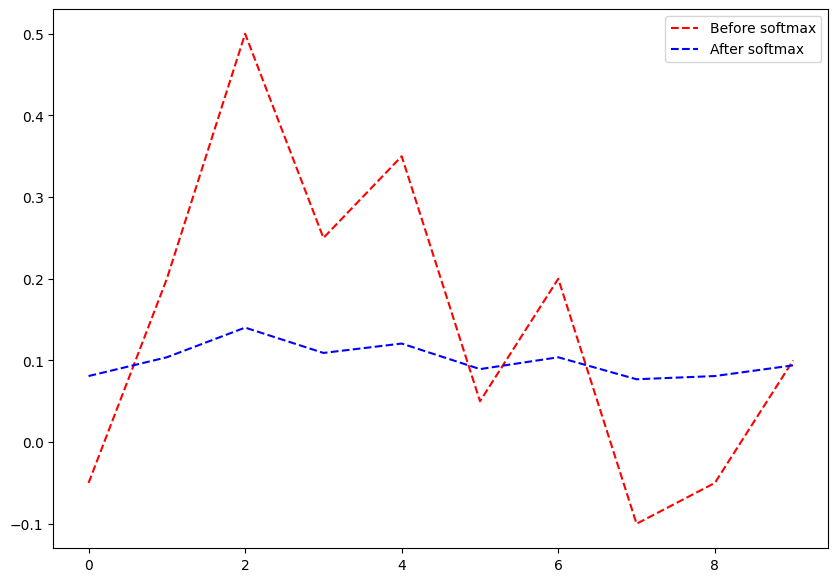

In [7]:
plt.figure(figsize = (10, 7))
plt.plot(list(range(10)), Y, "r--", label = "Before softmax")
plt.plot(list(range(10)), P, "b--", label = "After softmax")
plt.legend(loc = "best")
plt.show()

In the case of multi-label classification, we will use the softmax operation as the final operation after the last fully connected layer. This will produce a vector of 10 values, $ P = (p_0, p_1, p_2, ... p_9) $, corresponding to the probability of being of each class $ i $.

The predicted class $ pred $ will then be the index of the highest $ p_i $ value, i.e.

$$ pred = \arg\max_i [p_i]. $$

### Implementing a Shallow Neural Network with torch.nn.Linear

Below is a simple implementation of a shallow neural network.

To make its implementation simpler, we will replace the typical $ Wx + b $ operation, by its equivalent in PyTorch, which is the torch.nn.Linear() one (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

This will simplify the code in our init method, as we no longer have to specify them explicitly by doing this:

```
self.W1 = torch.nn.Parameter(torch.randn(n_x, n_h, requires_grad = True, \
                             dtype = torch.float64, device = device)*0.1)
self.b1 = torch.nn.Parameter(torch.randn(1, n_h, requires_grad = True, \
                             dtype = torch.float64, device = device)*0.1)
self.W2 = torch.nn.Parameter(torch.randn(n_h, n_y, requires_grad = True, \
                             dtype = torch.float64, device = device)*0.1)
self.b2 = torch.nn.Parameter(torch.randn(1, n_y, requires_grad = True, \
                             dtype = torch.float64, device = device)*0.1)
self.W1.retain_grad()
self.b1.retain_grad()
self.W2.retain_grad()
self.b2.retain_grad()
```

We simply rewrite this as two nn.Linear() layers, stored in two attributes.

```
self.fc1 = torch.nn.Linear(n_x, n_h)
self.fc2 = torch.nn.Linear(n_h, n_y)
```

We can then simply replace the operations in the forward method to make it simpler:

```
Z1 = torch.matmul(inputs, self.W1)
Z1_b = Z1 + self.b1
```

It simply becomes:

```
x = self.fc1(x)
```

The adaptation of our Shallow Neural Network class for multi-label classification is then shown below.

In [8]:
class ShallowNeuralNet(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y):
        super().__init__()
        # Define two layers using the nn.Linear()
        self.fc1 = torch.nn.Linear(n_x, n_h)
        self.fc2 = torch.nn.Linear(n_h, n_y)
    
    def forward(self, x):
        # Flatten images (transform them from 28x28 2D matrices to 784 1D vectors)
        x = x.view(x.size(0), -1)
        # First Wx + b operation
        out1 = self.fc1(x)
        # Using ReLU operation as activation after first layer
        act1 = torch.relu(out1)
        # Second Wx + b operation anbd return
        out2 = self.fc2(act1)
        return out2

### Forward pass on our shallow neural network

Let us start by initializing a neural network model, with 784 input nodes, 128 hidden nodes, and 10 output nodes. It is then transferring the model to a device, which could be a CPU or a GPU.

Next, the code is getting a single sample from the train_loader iterator and assigning it to the variables data and target. This can be simply done with the next and iter functions. It is then printing the shape of data and target, and then selecting the first element of each and transferring them to the device (cpu or gpu).

Finally, the code is performing a forward pass through the model by calling it on data1 and storing the output in the variables out2, which is then printed. 

Finally, we will apply the softmax operation as the final operation at the end of the forward method. Pytorch offers functional implementation of the softmax, as:

```
act2 =  torch.nn.functional.softmax(out2, dim = 1)
```

We can verify that it consists of values summing up to 1.

In [9]:
# Initialize model
model = ShallowNeuralNet(n_x = 784, n_h = 128, n_y = 10).to(device)

# Get a single sample
sample = next(iter(train_loader))
data, target = sample
print(data.shape)
print(target.shape)
data1 = data[0].to(device)
target1 = target[0].to(device)
print(data1.shape)
print(target1)

# Forward pass
out2 = model(data1)
act2 =  torch.nn.functional.softmax(out2, dim = 1)
print(out2)
print(act2)
print(act2.sum())

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([1, 28, 28])
tensor(4, device='cuda:0')
tensor([[-0.2145, -0.0527, -0.1197, -0.0488,  0.2503, -0.1870, -0.1401,  0.1202,
          0.1220,  0.1017]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0812, 0.0954, 0.0892, 0.0958, 0.1292, 0.0834, 0.0874, 0.1134, 0.1136,
         0.1113]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


### Training our shallow neural network

As before,  the number of neurons in the input layer is specified by n_x, the number of neurons in the hidden layer is specified by n_h, and the number of neurons in the output layer is specified by n_y.

The model is constructed with these three arguments, and then it is moved to the specified device (either GPU or CPU) using the to() method.

Note that we have removed the softmax operation from the forward method. This is normal as the softmax operation will be used in the loss function, cross_entropy, which will be used in the trainer() function later.

Speaking of, in the case of the binary classification, we used the following loss function, namely the **log-likelihood function**.

$$ \begin{array}{ll} L(x, y, a, b) & = \displaystyle \frac{-1}{N} \sum_{k = 1}^N \: y_k \: ln\big(p(x_k)\big) \: + \: (1- y_k) \: ln\big(1 - p(x_k) \big) \end{array} $$
 
But in the case of MNIST, we have more than two classes, so how does the loss function change now that we have 10 classes? The adjustment is actually quite simple, and the cross entropy loss function simply rewrites as shown below:

$$ \begin{array}{ll} L(x, y, a, b) & = \displaystyle \frac{-1}{N} \sum_{k = 1}^N \sum_{i = 1}^{10} \: y_k^i \: ln\big( p_i(x_k) \big) \end{array} $$

In the formula above, $ p_i(x_k) $ denotes the probability of sample $ x_k $ of being of class $ i $. In other words, it is the $i$-th value of the ouput vector produced by the model for sample $ x_k $ after softmax has been applied. The value $ y_k^i $ is the ground truth value for sample $ x_k $. For instance, if the sample $ x_k $ is of class 2, we have:

$$ Y_k = (y_k^0, y_k^1, y_k^2, y_k^3, ... y_k^9) = (0, 0, 1, 0, ..., 0). $$

In [10]:
class ShallowNeuralNet(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y):
        super().__init__()
        # Define two layers using the nn.Linear()
        self.fc1 = torch.nn.Linear(n_x, n_h)
        self.fc2 = torch.nn.Linear(n_h, n_y)
    
    def forward(self, x):
        # Flatten images (transform them from 28x28 2D matrices to 784 1D vectors)
        x = x.view(x.size(0), -1)
        # First Wx + b operation
        out1 = self.fc1(x)
        # Using ReLU operation as activation after first layer
        act1 = torch.relu(out1)
        # Second Wx + b operation and return
        out2 = self.fc2(act1)
        return out2

The optimizer is an instance of the Adam optimizer from PyTorch's torch.optim package, which is being used to optimize the model's parameters. The learning rate for the optimizer is specified by the lr argument, which is set to 1e-3 (0.001).

In [11]:
# Initialize the model and optimizer
model = ShallowNeuralNet(n_x = 784, n_h = 64, n_y = 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

We can then train the neural network for 10 iterations (or epochs), as shown below.

In addition, let us introduce a new good practice. In PyTorch, model.eval() sets the model to evaluation mode, which turns off certain features of certain special layers, such as dropout and batch normalization (which will be discussed next week). This is useful when you want to evaluate the model's performance on a dataset or make predictions using the model.

To set the model back to training mode, you can use model.train(). This will enable features such as dropout and batch normalization, which are typically used during training to improve the model's generalization ability.

In [12]:
# Training model
num_epochs = 5
for epoch in range(num_epochs):
    
    # Go trough all samples in train dataset
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Get from dataloader and send to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Display
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
    # Compute model accuracy on test after all samples have been seen using test samples
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Get images and labels from test loader
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass and predict class using max
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy and display
    accuracy = correct/total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')

Epoch [1/5], Step [100/938], Loss: 0.3224
Epoch [1/5], Step [200/938], Loss: 0.2368
Epoch [1/5], Step [300/938], Loss: 0.1558
Epoch [1/5], Step [400/938], Loss: 0.3353
Epoch [1/5], Step [500/938], Loss: 0.1821
Epoch [1/5], Step [600/938], Loss: 0.2206
Epoch [1/5], Step [700/938], Loss: 0.2275
Epoch [1/5], Step [800/938], Loss: 0.1729
Epoch [1/5], Step [900/938], Loss: 0.2104
Epoch [1/5], Accuracy: 0.9515
Epoch [2/5], Step [100/938], Loss: 0.1136
Epoch [2/5], Step [200/938], Loss: 0.1794
Epoch [2/5], Step [300/938], Loss: 0.2299
Epoch [2/5], Step [400/938], Loss: 0.1461
Epoch [2/5], Step [500/938], Loss: 0.1827
Epoch [2/5], Step [600/938], Loss: 0.0884
Epoch [2/5], Step [700/938], Loss: 0.1237
Epoch [2/5], Step [800/938], Loss: 0.0819
Epoch [2/5], Step [900/938], Loss: 0.0794
Epoch [2/5], Accuracy: 0.9625
Epoch [3/5], Step [100/938], Loss: 0.0576
Epoch [3/5], Step [200/938], Loss: 0.0707
Epoch [3/5], Step [300/938], Loss: 0.0875
Epoch [3/5], Step [400/938], Loss: 0.0370
Epoch [3/5], Ste

### Trying the forward pass again

As before, to visualize the softmax effect.

In [13]:
# Get a single sample
sample = next(iter(train_loader))
data, target = sample
print(data.shape)
print(target.shape)
data1 = data[0].to(device)
target1 = target[0].to(device)
print(data1.shape)
print(target1)

# Forward pass
act2 = torch.nn.functional.softmax(model(data1), dim = 1)
print(act2)

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([1, 28, 28])
tensor(4, device='cuda:0')
tensor([[3.8977e-04, 2.7913e-07, 1.1498e-04, 2.7697e-07, 9.1790e-01, 2.0434e-05,
         9.1618e-07, 4.3274e-06, 2.8502e-07, 8.1571e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


### From Shallow to Deep Neural Networks and the need for custom layers

It is now time for us to define and train our first Deep Neural Network.

By definition, our deep neural network here consists of four layers: three dense layers with ReLU activation, followed by one dense layer with softmax activation.

The sizes for each layer will decrease progressively to envetually produce n_y = 10 features at the output of the overall network. In general, it is good practice to have the size decrease by a factor 2 from one layer to another. For instance, we decide here, to have
- the first layer receive an input of size 784 and produce an output of size 80,
- the second layer receive an input of size 80 and produce an output of size 80,
- the third layer receive an input of size 40 and produce an output of size 40,
- and the fourth layer receive an input of size 20 and produce an output of size 10.

The DenseReLU class below is a custom PyTorch module that consists of a linear layer (nn.Linear(n_x, n_y)) followed by a ReLU activation function (torch.relu()). The DenseNoRELU class is similar, but it applies no activation function after the linear layer. 

The DeepNeuralNet class represents the overall deep neural network. It initializes the four layers defined in DenseReLU and DenseSoftmax, and combines them into a single PyTorch sequential model using torch.nn.Sequential(). The forward pass of the network is then defined in the forward method: the input is first flattened from a 2D image to a 1D vector, and then passed through the combined layers using the (combined_layers)(x) notation.

This modular approach, which defines blocks or layers and eventually assembles them in a larger network is very common in deep neural networks, especially when the architectures are very heavy and include many layers.

**Important note:** YOu have probably realized that the softmax operation has disappeared

In [14]:
class DenseReLU(torch.nn.Module):
    def __init__(self, n_x, n_y):
        super().__init__()
        # Define Linear layer using the nn.Linear()
        self.fc = torch.nn.Linear(n_x, n_y)
    
    def forward(self, x):
        # Wx + b operation
        # Using ReLU operation as activation after
        return torch.relu(self.fc(x))

In [15]:
class DenseNoReLU(torch.nn.Module):
    def __init__(self, n_x, n_y):
        super().__init__()
        # Define Linear layer using the nn.Linear()
        self.fc = torch.nn.Linear(n_x, n_y)
    
    def forward(self, x):
        # Wx + b operation
        # No activation function
        return self.fc(x)

In [16]:
class DeepNeuralNet(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y):
        super().__init__()
        # Define three Dense + ReLU layers,
        # followed by one Dense + Softmax layer
        self.layer1 = DenseReLU(n_x, n_h[0])
        self.layer2 = DenseReLU(n_h[0], n_h[1])
        self.layer3 = DenseReLU(n_h[1], n_h[2])
        self.layer4 = DenseNoReLU(n_h[2], n_y)
        
        # Combine all four layers
        self.combined_layers = torch.nn.Sequential(self.layer1,
                                                   self.layer2,
                                                   self.layer3,
                                                   self.layer4)

    
    def forward(self, x):
        # Flatten images (transform them from 28x28 2D matrices to 784 1D vectors)
        x = x.view(x.size(0), -1)
        # Pass through all four layers
        out = self.combined_layers(x)
        return out

Eventually, we can, just like before train our deep neural network. The only part that changes is the n_h parameter in the initialization of the model, everything else remains the same.

```
model = DeepNeuralNet(n_x = 784, n_h = [80, 40, 20], n_y = 10).to(device)
```

In [17]:
# Initialize the model and optimizer
model = DeepNeuralNet(n_x = 784, n_h = [80, 40, 20], n_y = 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [18]:
# Training model
num_epochs = 5
for epoch in range(num_epochs):
    
    # Go trough all samples in train dataset
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Get from dataloader and send to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Display
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
    # Compute model accuracy on test after all samples have been seen using test samples
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Get images and labels from test loader
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass and predict class using max
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy and display
    accuracy = correct/total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')

Epoch [1/5], Step [100/938], Loss: 0.5484
Epoch [1/5], Step [200/938], Loss: 0.4279
Epoch [1/5], Step [300/938], Loss: 0.3184
Epoch [1/5], Step [400/938], Loss: 0.2013
Epoch [1/5], Step [500/938], Loss: 0.4541
Epoch [1/5], Step [600/938], Loss: 0.2555
Epoch [1/5], Step [700/938], Loss: 0.1568
Epoch [1/5], Step [800/938], Loss: 0.2005
Epoch [1/5], Step [900/938], Loss: 0.2028
Epoch [1/5], Accuracy: 0.9393
Epoch [2/5], Step [100/938], Loss: 0.1004
Epoch [2/5], Step [200/938], Loss: 0.3163
Epoch [2/5], Step [300/938], Loss: 0.1155
Epoch [2/5], Step [400/938], Loss: 0.1973
Epoch [2/5], Step [500/938], Loss: 0.2456
Epoch [2/5], Step [600/938], Loss: 0.2013
Epoch [2/5], Step [700/938], Loss: 0.0996
Epoch [2/5], Step [800/938], Loss: 0.1061
Epoch [2/5], Step [900/938], Loss: 0.0521
Epoch [2/5], Accuracy: 0.9577
Epoch [3/5], Step [100/938], Loss: 0.2009
Epoch [3/5], Step [200/938], Loss: 0.1543
Epoch [3/5], Step [300/938], Loss: 0.0366
Epoch [3/5], Step [400/938], Loss: 0.0228
Epoch [3/5], Ste

### Number of layers/neurons vs overfitting tradeoff, and what's next?

This raises a question: **what is the appropriate number of layers to use and how many neurons should we use on each layer?**

There is no fixed rule for how many layers should be used in a deep neural network. The number of layers, as well as the number of neurons in each layer, should be chosen based on the complexity of the task and the amount of available data.

In general, deep neural networks with many layers (hundreds or even thousands) can learn very complex patterns in data, but they also require a large amount of data and computational resources to train. If the network is too deep, it may also be prone to overfitting, which can hinder its generalization performance on unseen data.

On the other hand, shallow networks with fewer layers may be easier to train and require less data, but they may not be able to learn as complex patterns and may not achieve as high performance on some tasks.

Finding the optimal number of layers and the optimal architecture of a deep neural network is often a trade-off between model complexity, computational resources, and performance, and requires some experimentation and model selection.

This is typically a good practice when it comes to training Deep Neural Networks and something we will investigate in the next notebook.